In [1]:
# Only for Colab, comment out if not using Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../..' 

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX' 

In [3]:
import sys
from os.path import join as ospj

sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

### Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![](../../data/exercise-3/fig1.png)

a) Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification. The code to train the model is already provided. Train the above model and report the training and validation accuracies. (5 points)

Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`.

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, the string contains the total number of trainable parameters for the entire model. (2 points)

![](../../data/exercise-3/fig2.png)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2 Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [4]:
from torchvision import transforms

from utils.parse_config import ConfigParser
from trainers.cnn_trainer import CNNTrainer
import data_loaders.data_modules as module_data

from copy import deepcopy
%aimport -ConfigParser # Due to an issue of pickle and auto_reload

In [5]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT)

datamodule = config.init_obj('data_module', module_data,
                             root_dir=PROJECT_ROOT #Just add the root_dir to the rest of the arguments defined in config file
                            )

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
# And get the loader from it
test_loader = test_module.get_loader()

transformations for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transformations for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


/home/hlcv_team002/miniconda3/envs/hlcv-ss23/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


ConvNet(
  (_activation): ReLU()
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Identity()
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Identity()
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Identity()
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dropout2d(p=0.1, inplace=False)
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): Identity()
    (19): ReLU()
    (20): MaxPoo

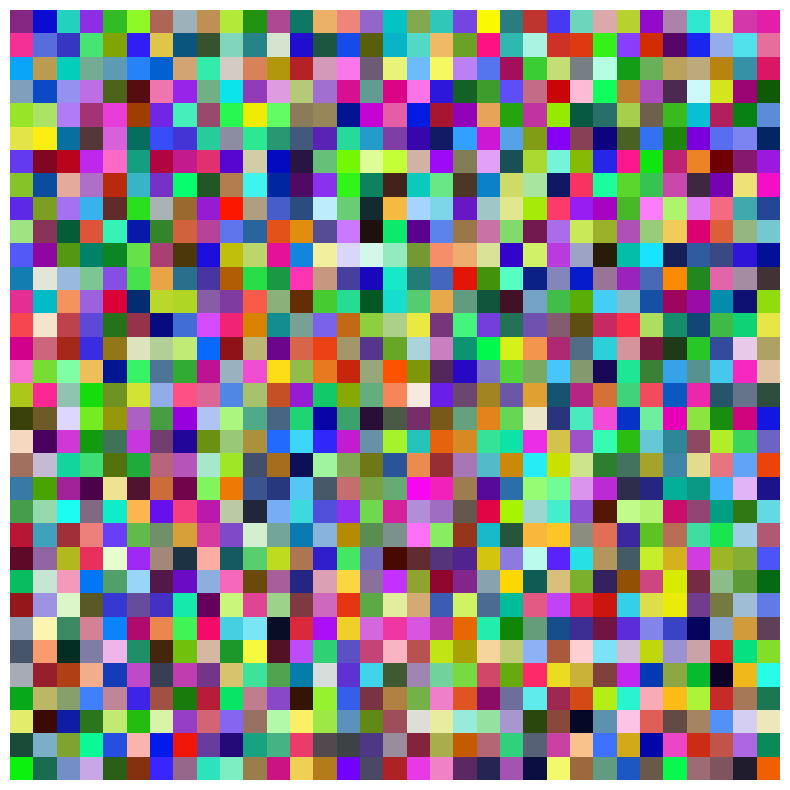

In [6]:
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

trainer_cnn.model.VisualizeFilter()


In [ ]:
trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()


In [ ]:
# Change this to the experiment you want to visualize (format is `MMDD_TIME`)
checkpoint_dir = '0607_121554' 
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{checkpoint_dir}/best_val_model.pth')

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

#### Wirte your report for Q1 in this cell.

The CIFAR-10 CNN model was trained for 10 epochs. The best model was saved at epoch 10, with the following metrics:

- Training loss: 0.6097
- Training top-1 accuracy: 78.42%
- Evaluation loss: 0.7092
- Evaluation top-1 accuracy: 76.52%

The model achieved an evaluation top-1 accuracy of 76.52%, indicating its ability to classify the CIFAR-10 dataset with high accuracy.

### Question 2: Improve training of Convolutional Networks (15 points)

In [ ]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/q1a_cnn_cifar10.json', root_dir=PROJECT_ROOT)
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
trainer_cnn.train()

result = trainer_cnn.evaluate(loader=test_loader)

print('Q1.a')
print(result)

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations are in the order of convolution, batch normalization, pooling, and ReLU. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

In [ ]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/q2a_cnn_cifar10.json', root_dir=PROJECT_ROOT)
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
trainer_cnn.train()

result = trainer_cnn.evaluate(loader=test_loader)

print('Q2.a')
print(result)

Wirte your report for Q2.a in this cell. Feel free to add extra code cells:

Q2.a Report
Test results:
Q1.a
{'loss': 0.8115487611293792, 'top1': 0.7649000000000001, 'top5': 0.9843999999999999}
Q2.a
{'loss': 0.8006674289703369, 'top1': 0.8500999999999999, 'top5': 0.9910000000000001}

As we can see, the top accurcy improves by almost 9% which is a huge increse really showing the impact of batch normalization. The top5 accuracy improved by about 0.6%, the shows that batch normalization helps the fine grain decisions.

b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with ever step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you should not do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we have already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.
We also recommend adding a few prints, such as the epochs that you save the best model at.

Increase the training epochs to 50 in Q1.a and Q2.a, and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)
Feel free to add any needed train/evaluation code below for this task.

You can also add extra code to `base_trainer.py` so that it returns extra information after the training is finished. For example, in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config). 

In [ ]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/q2b_cnn_cifar10.json', root_dir=PROJECT_ROOT)
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
trainer_cnn.train()

result = trainer_cnn.evaluate(loader=test_loader)

print('Q2.b')
print(result)

Wirte your report for Q2.b in this cell. Feel free to add extra code cells

#### Run 1 
##### Last Model:
- Epoch 50 improved: False (loss: 0.8664000000000001) (best: 0.8704000000000001)
-     epoch          : 50
-     loss           : 0.004294922570891989
-     top1           : 0.9985777777777786
-     top5           : 1.0
-     eval_loss      : 0.8261498022079468
-     eval_top1      : 0.8664000000000001
-     eval_top5      : 0.9934000000000001
    
##### Best Model:
- Epoch 46 improved: True (loss: 0.8704000000000001) (best: 0.8696)
- Saving checkpoint: ../../saved/models/CIFAR10_CNN/0607_143103/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 46
-     epoch          : 46
-     loss           : 0.0035288495176872756
-     top1           : 0.9989777777777782
-     top5           : 1.0
-     eval_loss      : 0.7964597141742706
-     eval_top1      : 0.8704000000000001
-     eval_top5      : 0.9936000000000001


#### Run 2

##### Last Model
- Epoch 50 improved: False (loss: 0.8651999999999999) (best: 0.8711999999999999)
-     epoch          : 50
-     loss           : 0.005001549507400746
-     top1           : 0.9982000000000011
-     top5           : 1.0
-     eval_loss      : 0.8504986882209777
-     eval_top1      : 0.8651999999999999
-     eval_top5      : 0.9923999999999998

##### Best Model
- Epoch 44 improved: True (loss: 0.8711999999999999) (best: 0.8705999999999999)
- Saving checkpoint: ../../saved/models/CIFAR10_CNN/0607_160828/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 44
-     epoch          : 44
-     loss           : 0.005420059428951289
-     top1           : 0.9982444444444453
-     top5           : 1.0
-     eval_loss      : 0.7632241976261139
-     eval_top1      : 0.8711999999999999
-     eval_top5      : 0.9915999999999999
    
    
#### Report 
The best model was found at epoch 46, while the training accuracy is almost equal (a little better for the last model), the eval top1 accuracy of the best model is about 0.4% better for the best model though. For the second run the eval top1 accuracy differences are similar, while the eval top5 accuracy is minimal worse. The best model was found 2 epochs earlier, at epoch 44.


c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented in `train` method in `base_trainer.py` (which takes care of running multiple epochs). You need to implement it at the end of the loop over epochs.

Once implemented, you need to change the config file to enable early stopping. You can either modify `cfgs/exercise-3/cnn_cifar10.json` directly or simply create a copy at the same place under a different name and parse that config instead. Within the config file, modify the following "trainer" configs:
```JSON
{
    ...
    "trainer":{
        ...
        "monitor": "max eval_top1",
        "early_stop": 0 -> change to 4
    }
}
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs.

In [ ]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/q2c_cnn_cifar10.json', root_dir=PROJECT_ROOT)
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
trainer_cnn.train()

result = trainer_cnn.evaluate(loader=test_loader)

print('Q2.c')
print(result)

Wirte your report for Q2.c in this cell. Feel free to add extra code cells

##### Best Model from Q2.c
- Epoch 16 improved: True (loss: 0.8591999999999999) (best: 0.8584)
- Saving checkpoint: ../../saved/models/CIFAR10_CNN/0607_150230/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 16
-     epoch          : 16
-     loss           : 0.035746462415489885
-     top1           : 0.9875111111111134
-     top5           : 1.0
-     eval_loss      : 0.6628348636627197
-     eval_top1      : 0.8591999999999999
-     eval_top5      : 0.9945999999999999
- ...
- ==> Start Training Epoch 20/50, lr=0.001024 
- ==> Finished Epoch 20/50.
- ++> Evaluate at epoch 20 ...
- ++> Evaluate epoch 20 Finished.
- Epoch 20 improved: False (loss: 0.8588) (best: 0.8591999999999999)
- Validation performance didn't improve for 4 epochs. Stop training.



##### Best Model from Q2.b
- Epoch 46 improved: True (loss: 0.8704000000000001) (best: 0.8696)
- Saving checkpoint: ../../saved/models/CIFAR10_CNN/0607_143103/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 46
-     epoch          : 46
-     loss           : 0.0035288495176872756
-     top1           : 0.9989777777777782
-     top5           : 1.0
-     eval_loss      : 0.7964597141742706
-     eval_top1      : 0.8704000000000001
-     eval_top5      : 0.9936000000000001
    
    
#### Report 
The model resulting after epoch 16 only differs from the model achieved at epoch 46 by a little more than 1% top1 accuracy. This is a huge saving of computational resources compared to small accuracy difference.

### Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on. The first is to get more training data. This might be a difficult and expensive process involving significant. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model. In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.

a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. (4 points)

Wirte your report for Q3 in this cell. Feel free to add extra code cells

- The best model with data augumentation achieved a validation loss of 0.845, top-1 accuracy of 70.4%, and top-5 accuracy of 97.9%.

### Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization (set `"fine_tune"` to `true` in `vgg_cifar10.json`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the same entire network is trained from scratch, without loading the ImageNet weights (set `"pretrained"` to `false` in `vgg_cifar10.json`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)

In [ ]:
from trainers.vgg_trainer import VGGTrainer

 By default WandB is enabled in config file for vgg_cifar10.json. You can set it to false if you don't want to use it.

In [ ]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/vgg_cifar10.json', root_dir=PROJECT_ROOT)

wandb_enabled = config['wandb']
if wandb_enabled:
    import wandb

datamodule = config.init_obj('data_module', module_data,
                             root_dir=PROJECT_ROOT #Just add the root_dir to the rest of the arguments defined in config file
                            )

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

if wandb_enabled:
    # change entity to your wandb username/group name. Also feel free to rename project and run names.
    run = wandb.init(project="hlcv-exercise-3", name="vgg_cifar10", config=config, entity="malouda-triangle", dir=PROJECT_ROOT)
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run

trainer_vgg = VGGTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
# And get the loader from it
test_loader = test_module.get_loader()

In [ ]:
trainer_vgg.train()

In [ ]:
# Change this to the experiment you want to visualize (format is `MMDD_TIME`)
checkpoint_dir = '0523_215742' 
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_VGG/{checkpoint_dir}/best_val_model.pth')

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish. Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    wandb.alert(title="Training Finished", text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO)

    run.finish()

#### Write your report for Q4 in this cell.

#### Q4.a

##### Best Model
- Epoch 2 improved: True (loss: 0.6399999999999999) (best: 0.632)
- Saving checkpoint: ../../saved/models/CIFAR10_VGG/0607_153608/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 2
-    epoch          : 2
-    loss           : 0.9959342951244778
-    top1           : 0.6475333333333334
-    top3           : 0.9033111111111106
-    eval_loss      : 1.0316525387763977
-    eval_top1      : 0.6399999999999999
-    eval_top3      : 0.8919999999999999
- ==> Start Training Epoch 3/15, lr=0.000980
- ... Epoch 6 improved: False (loss: 0.6224000000000001) (best: 0.6399999999999999)
- Validation performance didn't improve for 4 epochs. Stop training.

Early stopping got activated early, choosing the second epoch as the best model, it already reaches a validation top1 accuracy of 0.639, which is in bound of the reference scores.


#### Q4.b

##### Pretrained
- Epoch 13 improved: True (loss: 0.8686) (best: 0.8679999999999999)
- Saving checkpoint: ../../saved/models/CIFAR10_VGG/0607_153658/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 13
-     epoch          : 13
-     loss           : 0.038532728080948195
-     top1           : 0.986911111111113
-     top3           : 0.9997555555555557
-     eval_loss      : 0.568251280784607
-     eval_top1      : 0.8686
-     eval_top3      : 0.9724


##### Not Pretrained

- Epoch 15 improved: True (loss: 0.8151999999999999) (best: 0.81)
- Saving checkpoint: ../../saved/models/CIFAR10_VGG/0607_164244/best_val_model.pth ...
- Checkpoint saved.
- New best model saved at epoch 15
-     epoch          : 15
-     loss           : 0.052805412678668895
-     top1           : 0.9823555555555563
-     top3           : 0.9996666666666668
-     eval_loss      : 0.8541441011428833
-     eval_top1      : 0.8151999999999999
-     eval_top3      : 0.9551999999999998

The best pretrained model was found at epoch 13, it is 5% better than the not pretrained model at epoch 15. Which is a rather small difference taking into account the pretained model was trained on the huge imagenet dataset. Both easily outperfom the model where we only train the classifier.